In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import jieba
import numpy as np

# 1.数据中含有字符串的时候，如何做特征抽取

In [8]:

def dictvec():
    """
    字典数据抽取
    :return: None
    """
    # 实例化
    # sparse改为True,输出的是每个不为零位置的坐标，稀疏矩阵可以节省存储空间
    # 矩阵中存在大量的0，sparse存储只记录非零位置，节省空间的作用

    # Vectorizer是矢量器
    dict = DictVectorizer(sparse=True)  # 把sparse改为True看看

    #每个样本都是一个字典，有三个样本
    data = dict.fit_transform(
        [{'city': '北京', 'temperature': 100},
         {'city': '上海', 'temperature': 60},
         {'city': '深圳', 'temperature': 30}]
    )

    # 字典中的一些类别数据，分别进行转换成特征
    print(dict.get_feature_names_out()) # ['city=上海' 'city=北京' 'city=深圳' 'temperature']
    print('-' * 50)

    # 三行四列的矩阵
    # 因为 city 被拆分成了'city=上海' 'city=北京' 'city=深圳' 三个特征
    print(data) # 稀疏矩阵
    print(type(data))
    print(data.toarray()) # ndarray
    print('-' * 50)


    # 去看每个特征代表的含义，逆转回去
    print(dict.inverse_transform(data))
    # [
    # {'city=北京': 1.0, 'temperature': 100.0},
    # {'city=上海': 1.0, 'temperature': 60.0},
    # {'city=深圳': 1.0, 'temperature': 30.0}
    # ]

    return None


dictvec()

<class 'str'>
['city=上海' 'city=北京' 'city=深圳' 'temperature']
--------------------------------------------------
  (0, 1)	1.0
  (0, 3)	100.0
  (1, 0)	1.0
  (1, 3)	60.0
  (2, 2)	1.0
  (2, 3)	30.0
<class 'scipy.sparse._csr.csr_matrix'>
[[  0.   1.   0. 100.]
 [  1.   0.   0.  60.]
 [  0.   0.   1.  30.]]
--------------------------------------------------
[{'city=北京': 1.0, 'temperature': 100.0}, {'city=上海': 1.0, 'temperature': 60.0}, {'city=深圳': 1.0, 'temperature': 30.0}]


# 2 一段英文文本如何变为数值类型

In [13]:

def couvec():
    # 实例化CountVectorizer
    # max_df, min_df整数：所有文档中，出现次数小于min的词会被丢弃。如果出现该词的文档数量大于max，丢弃该词
    # max_df, min_df小数：某个词的出现的次数／所有文档数量
    # min_df=2
    # 默认会去除单个字母的单词，默认认为这个词对整个样本没有影响,认为其没有语义
    vector = CountVectorizer(min_df=2)

    # 调用fit_transform输入并转换数据
    res = vector.fit_transform(
        ["life is  short,i like python life",
         "life is too long,i dislike python",
         "life is short"]
    )


    # 以逗号or空格，分割每个词
    # 不区分大小写
    print(vector.get_feature_names_out())
    print('-'*50)

    # 根据min=2，最终只留下4个词，所以3行4列的矩阵
    print(res)
    print(type(res))    # res是稀疏矩阵
    print('-'*50)

    # 对照feature_names，标记每个词出现的次数
    print(res.toarray())
    print('-'*50)

    #拿每个样本里的特征进行显示
    print(vector.inverse_transform(res))


couvec()

['is' 'life' 'python' 'short']
--------------------------------------------------
  (0, 1)	2
  (0, 0)	1
  (0, 3)	1
  (0, 2)	1
  (1, 1)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1
  (2, 0)	1
  (2, 3)	1
<class 'scipy.sparse._csr.csr_matrix'>
--------------------------------------------------
[[1 2 1 1]
 [1 1 1 0]
 [1 1 0 1]]
--------------------------------------------------
[array(['life', 'is', 'short', 'python'], dtype='<U6'), array(['life', 'is', 'python'], dtype='<U6'), array(['life', 'is', 'short'], dtype='<U6')]


# 一段汉字文本如何数值化，对于汉字不能用空格来分割

In [14]:

def countvec():
    """
    对文本进行特征值化,不统计，因为单个汉字字母没有意义,不统计
    :return: None
    """
    cv = CountVectorizer()

    data = cv.fit_transform(["人生苦短，我 喜欢 python python", "人生漫长，不用 python"])

    print(cv.get_feature_names_out())
    print('-'*50)

    print(data) #稀疏存储，只记录非零位置
    print('-'*50)

    print(data.toarray())
    print('-'*50)

    print(cv.inverse_transform(data))
    return None


countvec()

['python' '不用' '人生漫长' '人生苦短' '喜欢']
--------------------------------------------------
  (0, 3)	1
  (0, 4)	1
  (0, 0)	2
  (1, 0)	1
  (1, 2)	1
  (1, 1)	1
--------------------------------------------------
[[2 0 0 1 1]
 [1 1 1 0 0]]
--------------------------------------------------
[array(['人生苦短', '喜欢', 'python'], dtype='<U6'), array(['python', '人生漫长', '不用'], dtype='<U6')]


## 1.3 掌握如何对中文进行分词

In [3]:

def cutword():
    """
    通过jieba对中文进行分词
    三步走：cut、list、join
    :return:
    """
    con1 = jieba.cut("今天很残酷，明天更残酷，后天很美好，但绝大部分是死在明天晚上，所以每个人不要放弃今天。")

    con2 = jieba.cut("我们看到的从很远星系来的光是在几百万年之前发出的，这样当我们看到宇宙时，我们是在看它的过去。")

    con3 = jieba.cut("如果只用一种方式了解某样事物，你就不会真正了解它。了解事物真正含义的秘密取决于如何将其与我们所了解的事物相联系。")

    # print(type(con1))   # 生成器类型 <class 'generator'>
    # print('-' * 50)

    # 把生成器转换成列表
    content1 = list(con1)
    content2 = list(con2)
    content3 = list(con3)
    print(content1)
    print(content2)
    print(content3)

    # 把列表转换成字符串，每个词之间用空格隔开
    c1 = ' '.join(content1) # str
    c2 = ' '.join(content2)
    c3 = ' '.join(content3)

    return c1, c2, c3

cutword()

['今天', '很', '残酷', '，', '明天', '更', '残酷', '，', '后天', '很', '美好', '，', '但', '绝大部分', '是', '死', '在', '明天', '晚上', '，', '所以', '每个', '人', '不要', '放弃', '今天', '。']
['我们', '看到', '的', '从', '很', '远', '星系', '来', '的', '光是在', '几百万年', '之前', '发出', '的', '，', '这样', '当', '我们', '看到', '宇宙', '时', '，', '我们', '是', '在', '看', '它', '的', '过去', '。']
['如果', '只用', '一种', '方式', '了解', '某样', '事物', '，', '你', '就', '不会', '真正', '了解', '它', '。', '了解', '事物', '真正', '含义', '的', '秘密', '取决于', '如何', '将', '其', '与', '我们', '所', '了解', '的', '事物', '相', '联系', '。']


('今天 很 残酷 ， 明天 更 残酷 ， 后天 很 美好 ， 但 绝大部分 是 死 在 明天 晚上 ， 所以 每个 人 不要 放弃 今天 。',
 '我们 看到 的 从 很 远 星系 来 的 光是在 几百万年 之前 发出 的 ， 这样 当 我们 看到 宇宙 时 ， 我们 是 在 看 它 的 过去 。',
 '如果 只用 一种 方式 了解 某样 事物 ， 你 就 不会 真正 了解 它 。 了解 事物 真正 含义 的 秘密 取决于 如何 将 其 与 我们 所 了解 的 事物 相 联系 。')

In [11]:
def hanzivec():
    """
    中文特征值化
    :return: None
    """
    c1, c2, c3 = cutword() # jieba分词好的中文文本，就像结巴说出来的话
    print('-'*50)
    print(c1)
    print(c2)
    print(c3)
    print('-'*50)

    cv = CountVectorizer()

    data = cv.fit_transform([c1, c2, c3])

    print(cv.get_feature_names_out())
    print('-'*50)

    print(data)
    print('-'*50)

    print(data.toarray())

    return None


hanzivec()

['今天', '很', '残酷', '，', '明天', '更', '残酷', '，', '后天', '很', '美好', '，', '但', '绝大部分', '是', '死', '在', '明天', '晚上', '，', '所以', '每个', '人', '不要', '放弃', '今天', '。']
['我们', '看到', '的', '从', '很', '远', '星系', '来', '的', '光是在', '几百万年', '之前', '发出', '的', '，', '这样', '当', '我们', '看到', '宇宙', '时', '，', '我们', '是', '在', '看', '它', '的', '过去', '。']
['如果', '只用', '一种', '方式', '了解', '某样', '事物', '，', '你', '就', '不会', '真正', '了解', '它', '。', '了解', '事物', '真正', '含义', '的', '秘密', '取决于', '如何', '将', '其', '与', '我们', '所', '了解', '的', '事物', '相', '联系', '。']
--------------------------------------------------
今天 很 残酷 ， 明天 更 残酷 ， 后天 很 美好 ， 但 绝大部分 是 死 在 明天 晚上 ， 所以 每个 人 不要 放弃 今天 。
我们 看到 的 从 很 远 星系 来 的 光是在 几百万年 之前 发出 的 ， 这样 当 我们 看到 宇宙 时 ， 我们 是 在 看 它 的 过去 。
如果 只用 一种 方式 了解 某样 事物 ， 你 就 不会 真正 了解 它 。 了解 事物 真正 含义 的 秘密 取决于 如何 将 其 与 我们 所 了解 的 事物 相 联系 。
--------------------------------------------------
['一种' '不会' '不要' '之前' '了解' '事物' '今天' '光是在' '几百万年' '发出' '取决于' '只用' '后天' '含义'
 '如何' '如果' '宇宙' '我们' '所以' '放弃' '方式' '明天' '星系' '晚上' '某样' '残酷' '每个' '看到'
 '真正

## 1.4 tf-idf
### tf：该词在该文档中出现的次数/该文档的总词数
### idf：lg(总文档数量/出现该词的文档数量)

词频 (TF) 是一词语出现的次数除以该文件的总词语数。假如一篇文件的总词语数是100个，而词语“母牛”出现了3次，那么“母牛”一词在该文件中的词频就是3/100=0.03。一个计算文件频率 (IDF) 的方法是文件集里包含的文件总数除以测定有多少份文件出现过“母牛”一词。所以，如果“母牛”一词在1,000份文件出现过，而文件总数是10,000,000份的话，其逆向文件频率就是 lg(10,000,000 / 1,000)=4。最后的TF-IDF的分数为0.03 * 4=0.12。

词频tf是对词数(term count)的归一化，以防止它偏向长的文件。（同一个词语在长文件里可能会比短文件有更高的词数，而不管该词语重要与否。
平滑idf = log（N + 1/ N(x) + 1）


### 传给fit_transform的文本，英文可以直接传
### 如果是中文，则需要先分词（上面的cut就是为了分词，变得像英文一样），无需再拼接。

In [5]:
# 规范{'l1'，'l2'}，默认='l2'
# 每个输出行都有单位范数，或者：
#
# 'l2'：向量元素的平方和为 1。当应用 l2 范数时，两个向量之间的余弦相似度是它们的点积。
#
# 'l1'：向量元素的绝对值之和为 1。参见preprocessing.normalize。

# smooth_idf布尔值，默认 = True
# 通过在文档频率上加一来平滑 idf 权重，就好像看到一个额外的文档包含集合中的每个术语恰好一次。防止零分裂。
# idf = log（N + 1/ N(x) + 1）
# 比如训练集中有某个词，测试集中没有，就是生僻词，就会造成n(x)分母为零，log(n/n(x)),从而出现零分裂

def tfidfvec():
    """
    中文特征值化,计算tfidf值
    :return: None
    """
    c1, c2, c3 = cutword()

    print("-"*50)
    print([c1, c2, c3])
    print("-"*50)

    tf = TfidfVectorizer(smooth_idf=True)

    data = tf.fit_transform([c1, c2, c3])
    # data = tf.fit_transform(        ["life is  short,i like python life",
    #      "life is too long,i dislike python",
    #      "life is short"])

    print(tf.get_feature_names_out())
    print('-'*50)

    print(data)
    print('-'*50)

    print(data.toarray())

    return None


tfidfvec()

['今天', '很', '残酷', '，', '明天', '更', '残酷', '，', '后天', '很', '美好', '，', '但', '绝大部分', '是', '死', '在', '明天', '晚上', '，', '所以', '每个', '人', '不要', '放弃', '今天', '。']
['我们', '看到', '的', '从', '很', '远', '星系', '来', '的', '光是在', '几百万年', '之前', '发出', '的', '，', '这样', '当', '我们', '看到', '宇宙', '时', '，', '我们', '是', '在', '看', '它', '的', '过去', '。']
['如果', '只用', '一种', '方式', '了解', '某样', '事物', '，', '你', '就', '不会', '真正', '了解', '它', '。', '了解', '事物', '真正', '含义', '的', '秘密', '取决于', '如何', '将', '其', '与', '我们', '所', '了解', '的', '事物', '相', '联系', '。']
--------------------------------------------------
['今天 很 残酷 ， 明天 更 残酷 ， 后天 很 美好 ， 但 绝大部分 是 死 在 明天 晚上 ， 所以 每个 人 不要 放弃 今天 。', '我们 看到 的 从 很 远 星系 来 的 光是在 几百万年 之前 发出 的 ， 这样 当 我们 看到 宇宙 时 ， 我们 是 在 看 它 的 过去 。', '如果 只用 一种 方式 了解 某样 事物 ， 你 就 不会 真正 了解 它 。 了解 事物 真正 含义 的 秘密 取决于 如何 将 其 与 我们 所 了解 的 事物 相 联系 。']
--------------------------------------------------
['一种' '不会' '不要' '之前' '了解' '事物' '今天' '光是在' '几百万年' '发出' '取决于' '只用' '后天' '含义'
 '如何' '如果' '宇宙' '我们' '所以' '放弃' '方式' '明天' '星系' '晚上' '某样' '残酷' '每个'

# 2 特征处理，不同的特征拉到到同一个量纲

In [34]:
def mm():
    """
    归一化处理
    :return: NOne
    """
    # 归一化缺点 容易受极值的影响
    # feature_range代表归一化后的特征值范围，一般设置为(0,1),或者(-1,1),默认是(0,1)
    mm = MinMaxScaler(feature_range=(0, 1))

    data = mm.fit_transform([[90, 2, 10, 40], [60, 4, 15, 45], [75, 3, 13, 46]]) # 房子的信息

    print(data)
    print(type(data))

    return None
    #transform和fit_transform不同是，transform用于测试集，而且不会重新找最小值和最大值


mm()

[[1.         0.         0.         0.        ]
 [0.         1.         1.         0.83333333]
 [0.5        0.5        0.6        1.        ]]
<class 'numpy.ndarray'>


In [35]:
def stand():
    """
    标准化缩放，不是标准正态分布，是均值为0，方差为1的均匀分布
    :return:
    """
    std = StandardScaler()

    data = std.fit_transform([[1., -1., 3.], [2., 4., 2.], [4., 6., -1.]])

    # 计算的是特征之间的方差和均值
    print(data)
    print(type(data))
    print('-' * 50)

    print(std.mean_)
    print('-' * 50)

    print(std.var_)
    print('-' * 50)

    print(std.n_samples_seen_)  # 样本数

    return None


stand()

[[-1.06904497 -1.35873244  0.98058068]
 [-0.26726124  0.33968311  0.39223227]
 [ 1.33630621  1.01904933 -1.37281295]]
<class 'numpy.ndarray'>
--------------------------------------------------
[2.33333333 3.         1.33333333]
--------------------------------------------------
[1.55555556 8.66666667 2.88888889]
--------------------------------------------------
3


In [56]:
std1 = StandardScaler()
# 为了证明上面输出的结果的均值是为0的，方差为1
# 注意上面的结果是ndarray，这里传给fit_transform的是list
data1 = std1.fit_transform([[-1.06904497, -1.35873244, 0.98058068],
                           [-0.26726124, 0.33968311, 0.39223227],
                            [1.33630621, 1.01904933, -1.37281295]])

print(data1)  # 和原来一样，说明这些数据已经是均值为0，方差为1的分布
print('-' * 50)

# 均值
print(std1.mean_)
# 方差
print(std1.var_)

[[-1.06904497 -1.35873244  0.98058068]
 [-0.26726124  0.33968311  0.39223227]
 [ 1.33630621  1.01904933 -1.37281295]]
--------------------------------------------------
[0. 0. 0.]
[1.         1.         1.00000001]


In [57]:
(np.square(1-2.333)+np.square(2-2.333)+np.square(4-2.333))/3    # 计算方差

1.5555556666666668

In [58]:
(1-2.333)/np.sqrt(1.55555)

-1.068779614944516

## transform和fit_transform不同是，transform用于测试集，
### 不会重新找最小值和最大值,不会重新计算均值方差。而是用训练集的均值方差来进行标准化
### 训练集和测试集，默认服从同一分布，才能做预测

# 3 缺失值处理


In [61]:
# 删除，可以用pd和np
# 下面是填补
def im():
    """
    缺失值处理
    :return:NOne
    """
    # NaN, nan,特征的缺失值必须是这种形式，如果是？号(或者其他符号)，就要replace换成这种
    im = SimpleImputer(missing_values=np.nan, strategy='mean')

    data = im.fit_transform([[1, 2], [np.nan, 3], [7, 6], [3, 2]])

    print(data)

    return None


im()

[[1.         2.        ]
 [3.66666667 3.        ]
 [7.         6.        ]
 [3.         2.        ]]


# 4 降维
# 降维就是特征数变少
# 降维可以提高模型训练速度（模型的参数减少了）

In [40]:
def var():
    """
    特征选择-删除低方差的特征
    :return: None
    """
    #默认只删除方差为0,threshold是方差阈值，删除方差比这个值小的那些特征
    var = VarianceThreshold(threshold=0.1)

    data = var.fit_transform([[0, 2, 0, 3],
                              [0, 1, 4, 3],
                              [0, 1, 1, 3]])

    print(var.get_feature_names_out())
    print(data)

    # 获得剩余的特征的列编号
    print('The support is %s' % var.get_support(True))
    return None


var()


['x1' 'x2']
[[2 0]
 [1 4]
 [1 1]]
The support is [1 2]


In [62]:
def pca():
    """
    主成分分析进行特征降维
    :return: None
    """
    # n_ components:小数 0~1 业界选择 90~95%

    # 当n_components的值为0到1之间的浮点数时，表示我们希望保留的主成分解释的方差比例。
    # 具体而言，n_components=0.9表示我们希望选择足够的主成分，以使它们解释数据方差的90%

    # n_components如果是整数   减少到的特征数量

    # 原始数据方差
    print(np.var(np.array([[2, 8, 4, 5], [6, 3, 0, 8], [5, 4, 9, 1]]), axis=0))
    print(np.var(np.array([[2, 8, 4, 5], [6, 3, 0, 8], [5, 4, 9, 1]]), axis=0).sum())
    print('-'* 50)

    pca = PCA(n_components=0.95)

    data = pca.fit_transform([[2, 8, 4, 5], [6, 3, 0, 8], [5, 4, 9, 1]])

    # 降维后的数据
    print(data) # ndarray
    print('-'*50)

    #计算data的方差
    print(np.var(data, axis=0))
    print(np.var(data, axis=0).sum())
    print('-'*50)


    # 计算每个主成分的方差占总方差的比例
    print(pca.explained_variance_ratio_)
    # 计算data的方差占总方差的比例
    print(pca.explained_variance_ratio_.sum())

    return None


pca()

[ 2.88888889  4.66666667 13.55555556  8.22222222]
29.333333333333336
--------------------------------------------------
[[ 1.28620952e-15  3.82970843e+00]
 [ 5.74456265e+00 -1.91485422e+00]
 [-5.74456265e+00 -1.91485422e+00]]
--------------------------------------------------
[22.          7.33333333]
29.333333333333332
--------------------------------------------------
[0.75 0.25]
1.0


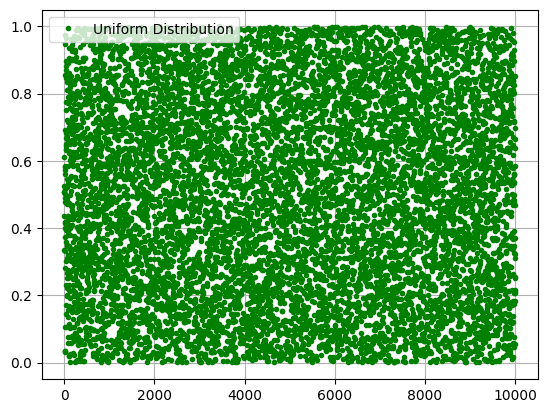

In [70]:
from matplotlib import pyplot as plt
x = np.random.rand(10000) #每个的概率
t = np.arange(len(x))
plt.plot(t,x,'g.',label="Uniform Distribution")
plt.legend(loc="upper left")
plt.grid()
plt.show()